In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import os
os.chdir('/content/drive/Othercomputers/PC/msc_final_project/TPU/attack/blackbox/SquareAttack')

In [47]:
try:
 import art
except ModuleNotFoundError:
 !pip install adversarial-robustness-toolbox # module doesn't exist, deal with it.

In [48]:
try:
 import cma
except ModuleNotFoundError:
 !pip install cma # module doesn't exist, deal with it.

In [49]:
! pip show adversarial-robustness-toolbox

Name: adversarial-robustness-toolbox
Version: 1.11.0
Summary: Toolbox for adversarial machine learning.
Home-page: https://github.com/Trusted-AI/adversarial-robustness-toolbox
Author: Irina Nicolae
Author-email: irinutza.n@gmail.com
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: six, scipy, numba, tqdm, scikit-learn, numpy, setuptools
Required-by: 


# 1. Config the Environment

In [50]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import sys


print(f'python version: {sys.version}')
print(f'tensorflow version: {tf.__version__}')
print(f'keras version: {keras.__version__}')
print(f'numpy version: {np.__version__}')

python version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
tensorflow version: 2.8.2
keras version: 2.8.0
numpy version: 1.21.6


In [51]:
from art.attacks.evasion import SquareAttack
from art.estimators.classification import TensorFlowV2Classifier

In [52]:
# Load data and normalize
from art.utils import load_cifar10
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']

In [53]:
x_train, y_train = tf.cast(x_train, tf.float32), tf.cast(y_train, tf.float32)

In [54]:
min_ = 0
max_ = 1

In [55]:
# Select 10 and 100 random simple from Test set to test the algorithm
random_sample_10 = np.random.randint(low = 0, high = 10000, size = 10)
random_sample_10 = np.sort(random_sample_10).tolist()

random_sample_100 = np.random.randint(low = 0, high = 10000, size = 100)
random_sample_100 = np.sort(random_sample_100).tolist()

x_test_10 = x_test[random_sample_10,:,:,:]
x_test_100 = x_test[random_sample_100,:,:,:]

y_test_10 = y_test[random_sample_10, :]
y_test_100 = y_test[random_sample_100, :]


In [56]:
x_test_10_ori = x_test_10.copy()
x_test_100_ori = x_test_100.copy()

# 2 Config DenseNet model

In [57]:
!wget 'https://gitlab.act.reading.ac.uk/vo836354/msc_final_project_model/-/raw/main/saved_model/DenseNet_TransferLearning/HDF5/DenseNet_TransferLearning.h5?inline=false' -O /content/DenseNet.h5

--2022-07-19 16:16:27--  https://gitlab.act.reading.ac.uk/vo836354/msc_final_project_model/-/raw/main/saved_model/DenseNet_TransferLearning/HDF5/DenseNet_TransferLearning.h5?inline=false
Resolving gitlab.act.reading.ac.uk (gitlab.act.reading.ac.uk)... 134.225.116.8
Connecting to gitlab.act.reading.ac.uk (gitlab.act.reading.ac.uk)|134.225.116.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28984144 (28M) [application/octet-stream]
Saving to: ‘/content/DenseNet.h5’

/content/DenseNet.h 100%[===================>]  27.64M   126MB/s    in 0.2s    

2022-07-19 16:16:28 (126 MB/s) - ‘/content/DenseNet.h5’ saved [28984144/28984144]



In [58]:
model = tf.keras.models.load_model('/content/DenseNet.h5', compile=True)

In [59]:
# Create the ART classifier, pass the model to the ART classifier

classifier = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(32, 32, 3), clip_values=(min_, max_))
#, clip_values=(min_, max_)

In [60]:
# Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 65.12%


# 3 Square Attack


## 3.1 Test Untarget Attack

### 3.1.1 L2 attack

In [61]:
attack = SquareAttack(estimator=classifier, norm=2, max_iter=1000, eps=5, p_init=0.8, nb_restarts=1, verbose=False)

Use 10 samples for showing difference and effects

In [62]:
x_test_adv = attack.generate(x=x_test_10_ori)

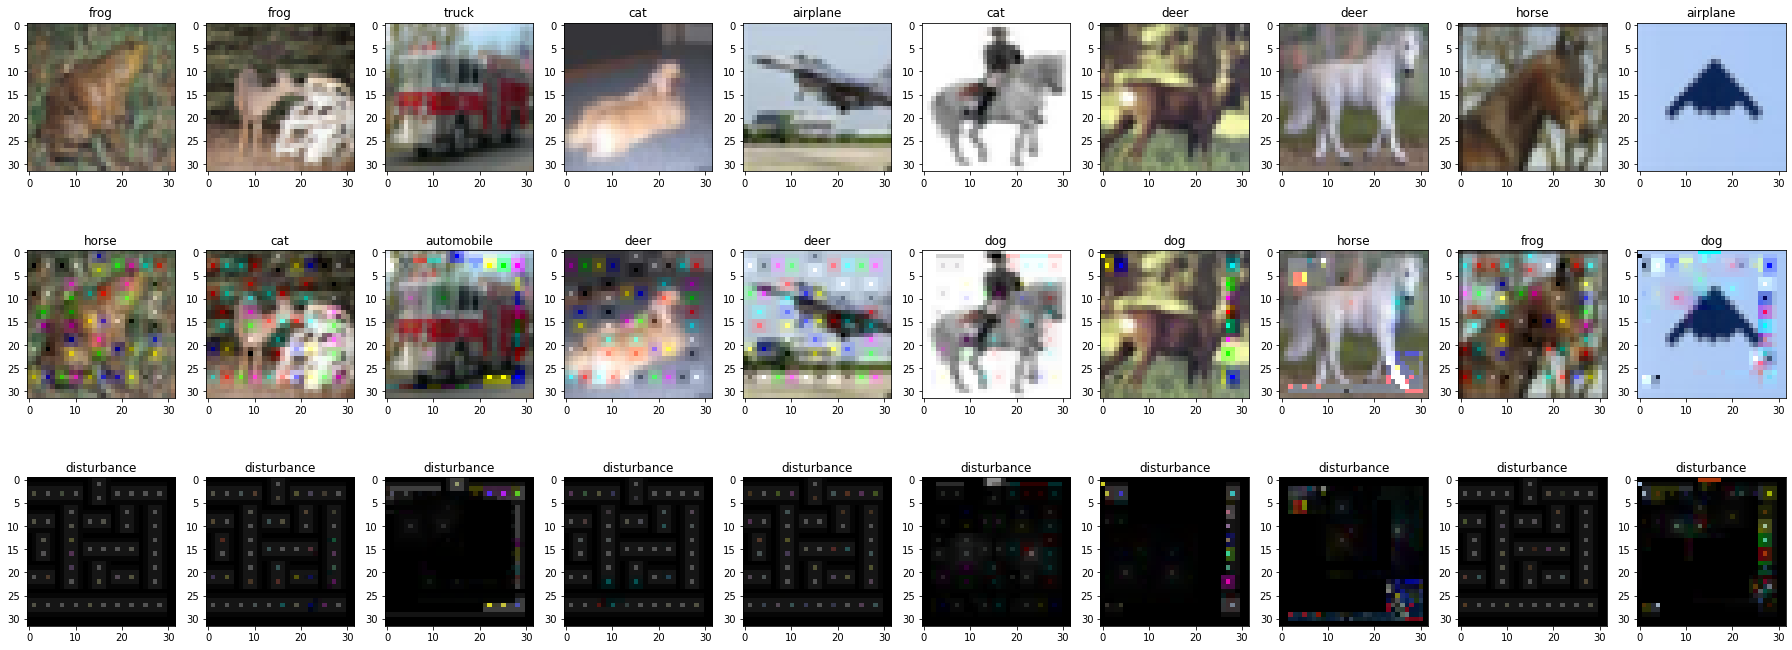

In [63]:
fig, axs = plt.subplots(3, len(x_test_adv), figsize = (25, 10))

for i in range(len(x_test_adv)):
  axs[0, i].imshow(x_test_10[i])
  axs[1, i].imshow(x_test_adv[i])
  axs[2, i].imshow(np.abs(x_test_10[i] -  x_test_adv[i]))
  axs[0, i].set_title(label_names[np.argmax(classifier.predict(x_test_10[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[1, i].set_title(label_names[np.argmax(classifier.predict(x_test_adv[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[2, i].set_title('disturbance')
  fig.tight_layout()

  
  

### 3.1.2 L-infinite attack

In [64]:
attack = SquareAttack(estimator=classifier, norm=np.inf, max_iter=1000, eps=0.05, p_init=0.8, nb_restarts=1, verbose=False)

Use 10 samples for showing difference and effects

In [65]:
x_test_adv = attack.generate(x=x_test_10_ori)

In [66]:
fig, axs = plt.subplots(3, len(x_test_adv), figsize = (25, 10))

for i in range(len(x_test_adv)):
  axs[0, i].imshow(x_test_10[i])
  axs[1, i].imshow(x_test_adv[i])
  axs[2, i].imshow(np.abs(x_test_10[i] -  x_test_adv[i]))
  axs[0, i].set_title(label_names[np.argmax(classifier.predict(x_test_10[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[1, i].set_title(label_names[np.argmax(classifier.predict(x_test_adv[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[2, i].set_title('disturbance')
  fig.tight_layout()

  
  

### 3.1.3 Test different Parameters with 100 random examples

In [67]:
with open ('./information/DenseNet.txt', 'a') as f:
  f.write("Test Untargeted attack accuracy:\n")

for norm in [2, np.inf]:
  for eps in [0.05, 2, 3, 5]:
    for p_init in [0.0125, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]:
      attack = SquareAttack(estimator=classifier, norm=norm, max_iter=1000, eps=eps, p_init=p_init, nb_restarts=1, verbose=False)

      x_test_adv = attack.generate(x=x_test_100_ori)

      predictions_adv = classifier.predict(x_test_adv)
      predictions_ori = classifier.predict(x_test_100_ori)

      accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)
      accuracy_ori = np.sum(np.argmax(predictions_ori, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)

      print(f"norm: {norm}, eps: {eps}, p_init: {p_init}, Accuracy before attack: {accuracy_ori * 100}%, Accuracy after attack: {accuracy_adv * 100}%")

      with open ('./information/DenseNet.txt', 'a') as f:
        f.write(f"norm: {norm}, eps: {eps}, p_init: {p_init}, Accuracy before attack: {accuracy_ori * 100}%, Accuracy after attack: {accuracy_adv * 100}%\n")

norm: 2, eps: 0.05, p_init: 0.0125, Accuracy before attack: 73.0%, Accuracy after attack: 75.0%


/usr/local/lib/python3.7/dist-packages/art/attacks/evasion/square_attack.py:476: RuntimeWarning: divide by zero encountered in true_divide
  diff_norm / channels + w_norm ** 2
/usr/local/lib/python3.7/dist-packages/art/attacks/evasion/square_attack.py:476: RuntimeWarning: invalid value encountered in true_divide
  diff_norm / channels + w_norm ** 2


norm: 2, eps: 0.05, p_init: 0.025, Accuracy before attack: 73.0%, Accuracy after attack: 74.0%
norm: 2, eps: 0.05, p_init: 0.05, Accuracy before attack: 73.0%, Accuracy after attack: 75.0%
norm: 2, eps: 0.05, p_init: 0.1, Accuracy before attack: 73.0%, Accuracy after attack: 75.0%
norm: 2, eps: 0.05, p_init: 0.15, Accuracy before attack: 73.0%, Accuracy after attack: 75.0%
norm: 2, eps: 0.05, p_init: 0.2, Accuracy before attack: 73.0%, Accuracy after attack: 75.0%
norm: 2, eps: 0.05, p_init: 0.25, Accuracy before attack: 73.0%, Accuracy after attack: 74.0%
norm: 2, eps: 0.05, p_init: 0.3, Accuracy before attack: 73.0%, Accuracy after attack: 75.0%
norm: 2, eps: 0.05, p_init: 0.35, Accuracy before attack: 73.0%, Accuracy after attack: 75.0%
norm: 2, eps: 0.05, p_init: 0.4, Accuracy before attack: 73.0%, Accuracy after attack: 74.0%
norm: 2, eps: 2, p_init: 0.0125, Accuracy before attack: 73.0%, Accuracy after attack: 14.000000000000002%
norm: 2, eps: 2, p_init: 0.025, Accuracy before at

## 3.2 Test Target Attack

In [68]:
def generate_random_target(ori_target, classes_num):
  class_y_test = np.argmax(ori_target, axis=1)
  nb_classes = np.unique(class_y_test).shape[0]
  targets = np.random.randint(nb_classes, size=len(ori_target))
  for i in range(len(ori_target)):
      if class_y_test[i] == targets[i]:
          targets[i] -= 1

  targets = tf.one_hot(targets, classes_num)

  return targets

##### 2.2.2.1 Use 10 samples for showing difference and effects

In [69]:
targets = generate_random_target(y_test_10, 10)

### 3.1.1 L2 attack

In [70]:
attack = SquareAttack(estimator=classifier, norm=2, max_iter=60000, eps=5, p_init=0.8, nb_restarts=1, verbose=False)

Use 10 samples for showing difference and effects

In [71]:
x_test_adv = attack.generate(x=x_test_10_ori, y=targets)

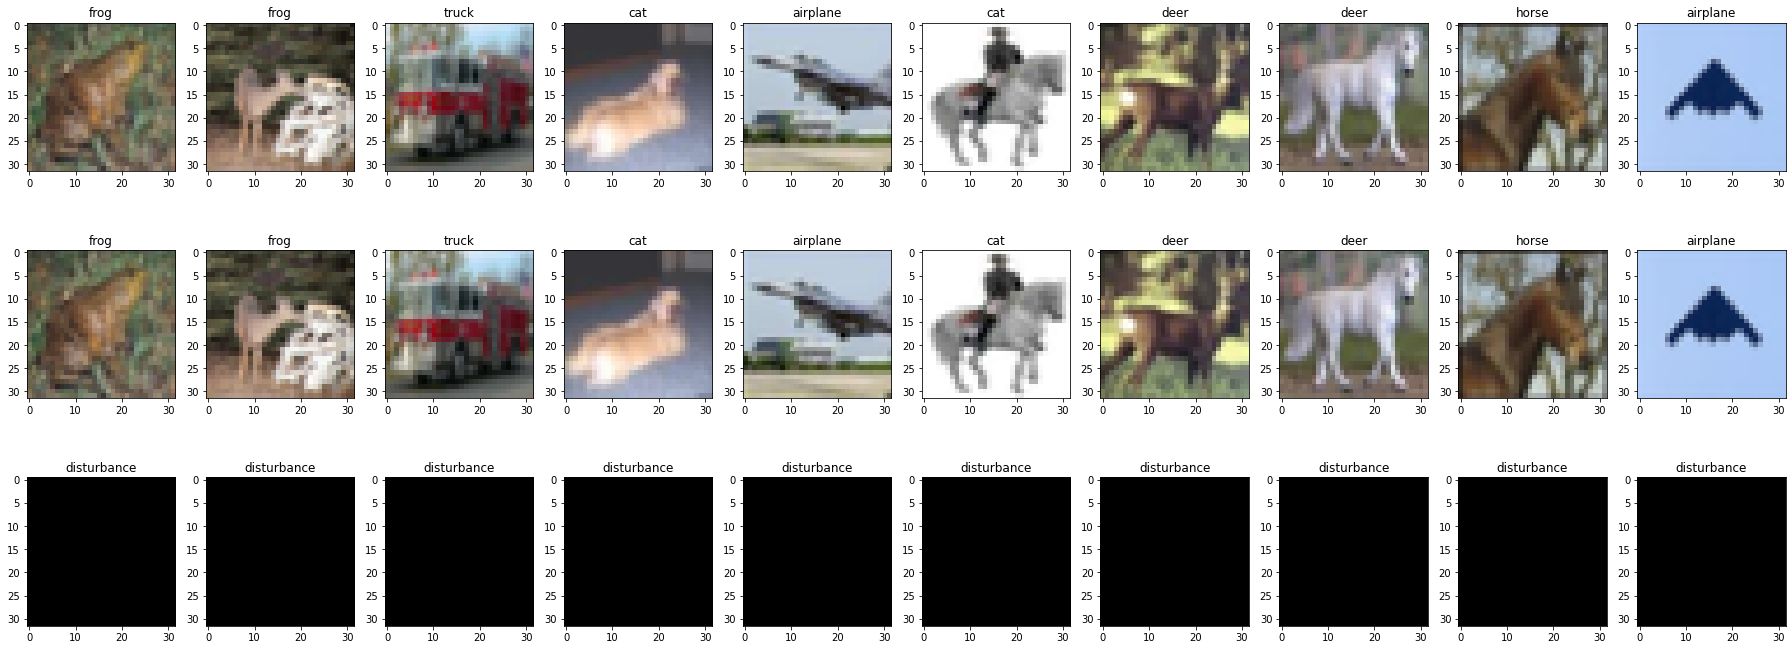

In [72]:
fig, axs = plt.subplots(3, len(x_test_adv), figsize = (25, 10))

for i in range(len(x_test_adv)):
  axs[0, i].imshow(x_test_10[i])
  axs[1, i].imshow(x_test_adv[i])
  axs[2, i].imshow(np.abs(x_test_10[i] -  x_test_adv[i]))
  axs[0, i].set_title(label_names[np.argmax(classifier.predict(x_test_10[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[1, i].set_title(label_names[np.argmax(classifier.predict(x_test_adv[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[2, i].set_title('disturbance')
  fig.tight_layout()

  
  

### 3.1.2 L-infinite attack

In [73]:
attack = SquareAttack(estimator=classifier, norm=np.inf, max_iter=100000, eps=0.05, p_init=0.8, nb_restarts=1, verbose=False)

Use 10 samples for showing difference and effects

In [74]:
x_test_adv = attack.generate(x=x_test_10_ori, y=targets)

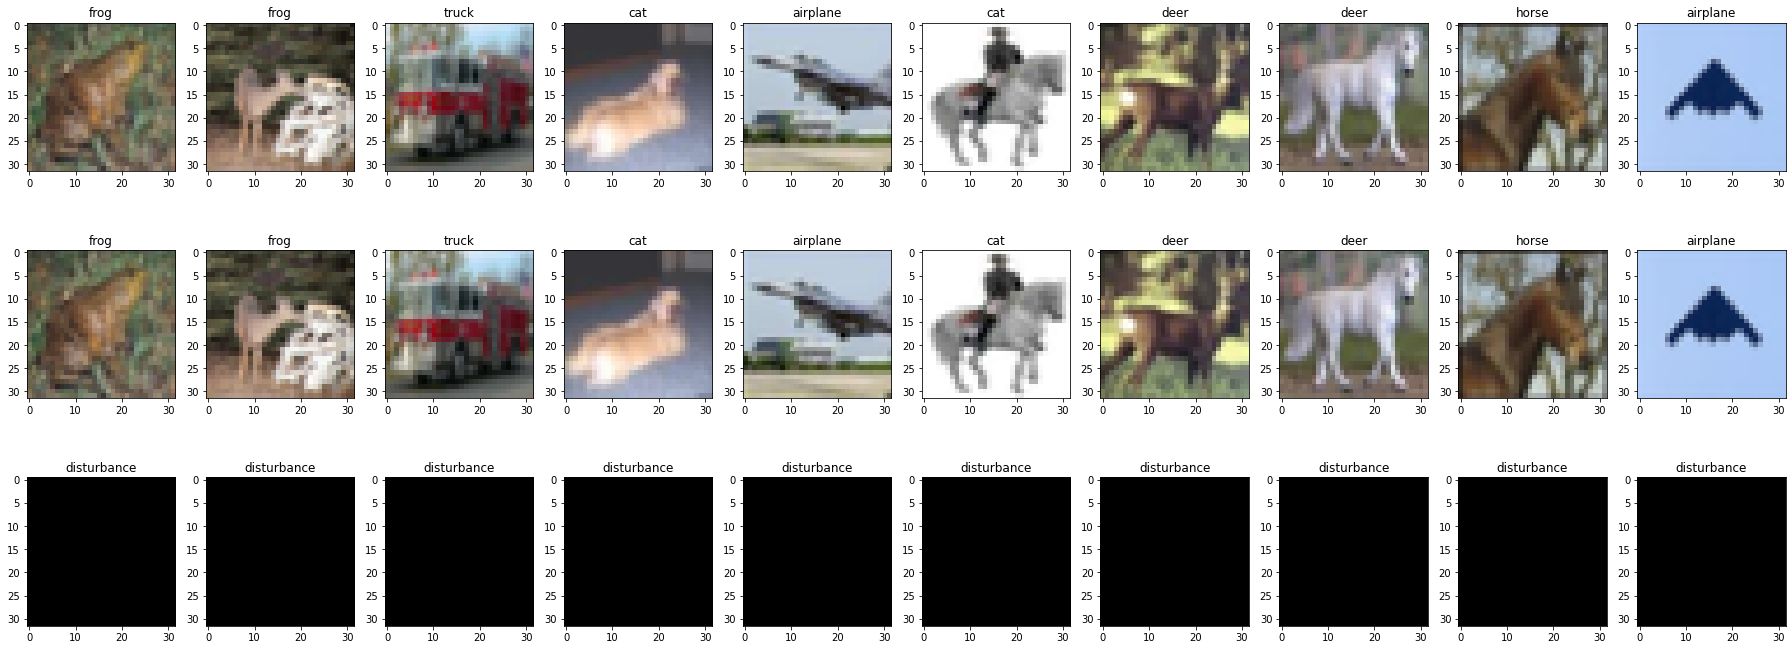

In [75]:
fig, axs = plt.subplots(3, len(x_test_adv), figsize = (25, 10))

for i in range(len(x_test_adv)):
  axs[0, i].imshow(x_test_10[i])
  axs[1, i].imshow(x_test_adv[i])
  axs[2, i].imshow(np.abs(x_test_10[i] -  x_test_adv[i]))
  axs[0, i].set_title(label_names[np.argmax(classifier.predict(x_test_10[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[1, i].set_title(label_names[np.argmax(classifier.predict(x_test_adv[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[2, i].set_title('disturbance')
  fig.tight_layout()

  
  

### 3.1.3 Test different Parameters with 100 random examples

In [ ]:
with open ('./information/DenseNet.txt', 'a') as f:
  f.write("Test targeted attack accuracy:\n")

for norm in [2, np.inf]:
  for eps in [0.05, 2, 3, 5]:
    for p_init in [0.0125, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]:

      if norm==2:
        max_iter=60000;
      else:
        max_iter=100000;

      attack = SquareAttack(estimator=classifier, norm=norm, max_iter=max_iter, eps=eps, p_init=p_init, nb_restarts=1, verbose=False)

      targets = generate_random_target(y_test_100, 100)

      x_test_adv = attack.generate(x=x_test_100_ori, y=targets)

      predictions_adv = classifier.predict(x_test_adv)
      predictions_ori = classifier.predict(x_test_100_ori)

      accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)
      accuracy_ori = np.sum(np.argmax(predictions_ori, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)

      print(f"norm: {norm}, eps: {eps}, p_init: {p_init}, Accuracy before attack: {accuracy_ori * 100}%, Accuracy after attack: {accuracy_adv * 100}%")

      with open ('./information/DenseNet.txt', 'a') as f:
        f.write(f"norm: {norm}, eps: {eps}, p_init: {p_init}, Accuracy before attack: {accuracy_ori * 100}%, Accuracy after attack: {accuracy_adv * 100}%\n")

norm: 2, eps: 0.05, p_init: 0.0125, Accuracy before attack: 73.0%, Accuracy after attack: 73.0%
